# MCMC CALIBRATION TECHNICS IN CONTEXT OF  INFECTIOUS DISEASE MODELING

## Prerequies

In [1]:
# pip install summerepi2 estival jax==0.4.24 jaxlib==0.4.24 nevergrad jupyter pymc numpyro

In [2]:
# pip install multiprocess
# %pip install --upgrade --force-reinstall multiprocess


In [3]:
# This is required for pymc parallel evaluation in notebooks

import multiprocess as mp
import platform

if platform.system() != "Windows":
    
    mp.set_start_method('forkserver')

In [4]:
import Calibrate as cal #Runing the calibration process and gathering results
from calibs_utilities import get_all_priors, get_targets, load_data
from models.models import model1 #All the models we design for the test
#from Calibrate import plot_comparison_bars

# Combining tagets and prior with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel


import pandas as pd
import plotly.express as px
pd.options.plotting.backend = "plotly" #To allow plotly graphic
import matplotlib.pyplot as plt

import pymc as pm


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Calibration Data
If data are needed to define a target, we just need to import it from our file data which we will design correctly.
In this example we import data from a YAML file.

In [5]:
#An example of data for the calibration 

output_labels = {"index": "time", "value": "number infectious"}

targets_yml = './data/target_yml.yml'
targets = load_data(targets_yml)
targets_data = targets['active_cases']

targets_data.plot(kind="scatter",labels=output_labels)



In [6]:


#Names of parameters and their ranges
params = {
    "contact_rate": (0.0,0.5),
    "recovery_rate": (0.0,0.8)

}
params
targets = get_targets(targets_yml)
priors = get_all_priors(params)

## Model Definition and Configuration

A mechanistic model (ODE-Based) model discribing Infectious Disease transmission.

In [7]:
model_1 = model1()

## Trial run 

In [8]:
parameters = {
    "contact_rate": 0.2,
    "recovery_rate": 0.1,
    #"active_cases_dispersion": 0.5,
}

model_1.run(parameters)


pd.DataFrame(
    {
        "modelled": model_1.get_outputs_df()["infectious"],
        "observed": targets_data,
    }
).plot(kind="scatter", labels=output_labels)

## Sampling 

In [9]:
#Defining  a Bayesian Compartmental Model
bcm = BayesianCompartmentalModel(model_1, parameters, priors, targets)

In [10]:
bcm.priors

{'contact_rate': UniformPrior contact_rate {bounds: (0.0, 0.5)},
 'recovery_rate': UniformPrior recovery_rate {bounds: (0.0, 0.8)}}

In [11]:
initial_parameters = {
"contact_rate": 0.15,
"recovery_rate": 0.1,
#"active_cases_dispersion": (0.5,1),
}
# #bcm.run(initial_parameters)
# for param, ranges in initial_parameters.items():
#     print(param)
#     print(ranges)


In [12]:
samplers = [pm.DEMetropolisZ] + [pm.DEMetropolis] + [pm.Metropolis]*2
print(samplers)

[<class 'pymc.step_methods.metropolis.DEMetropolisZ'>, <class 'pymc.step_methods.metropolis.DEMetropolis'>, <class 'pymc.step_methods.metropolis.Metropolis'>, <class 'pymc.step_methods.metropolis.Metropolis'>]


In [33]:
D = 2 # Dimension of the parameter's space
samplers = [pm.DEMetropolisZ]*2 + [pm.DEMetropolis]*2 + [pm.Metropolis]*4
Draws = [4000]*7 + [8000]
Tunes = [100] + [1000] + [100] + [1000] + [100] + [1000] + [100] + [1000]
chains = 2*D
results = []
for sampler, draws, tune in zip (samplers, Draws, Tunes):
    #print(sampler)
    idata, Time = cal.Sampling_calib(
        bcm_model = bcm,
        mcmc_algo = sampler,
        initial_params = initial_parameters,
        draws = draws,
        tune = tune,
        cores = 4,
        chains = chains,
        )

    results.append(cal.Compute_metrics(
        mcmc_algo = sampler,
        idata = idata,
        Time = Time,
        draws = draws, 
        chains = chains,
        tune = tune,
            )
        )


Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [contact_rate, recovery_rate]
Sampling 4 chains for 100 tune and 4_000 draw iterations (400 + 16_000 draws total) took 34 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [contact_rate, recovery_rate]
Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 31 seconds.
Population sampling (4 chains)
DEMetropolis: [contact_rate, recovery_rate]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.
Sampling 4 chains for 100 tune and 4_000 draw iterations (400 + 16_000 draws total) took 27 seconds.
The 

In [34]:
# results_df.drop(results_df.index, inplace=True)

results_df = pd.concat(results)
# results
results_df = results_df.reset_index(drop=True)
results_df.style.set_caption("MCMC COMPARISON")
# print(results_df.Sampler)

,Sampler,Draws,Chains,Tune,Time,Mean_ESS,Min_Ess,Ess_per_sec,Mean_Rhat,Rhat_max,Trace
0,DEMetropolisZ,4000,4,100,38.654072,27.149022,23.835340,0.702359,1.513327,1.532386,Inference data with groups: > posterior > sample_stats
1,DEMetropolisZ,4000,4,1000,34.611516,1296.665930,1274.890168,37.463424,1.006177,1.007032,Inference data with groups: > posterior > sample_stats
2,DEMetropolis,4000,4,100,29.934607,18.808592,16.133591,0.628323,1.410522,1.552053,Inference data with groups: > posterior > sample_stats
3,DEMetropolis,4000,4,1000,32.783038,714.322371,708.032948,21.789389,1.006147,1.006278,Inference data with groups: > posterior > sample_stats
4,metropolis,4000,4,100,34.617888,5.308233,5.299369,0.153338,2.051570,2.055366,Inference data with groups: > posterior > sample_stats
5,metropolis,4000,4,1000,37.075520,5.442905,5.439703,0.146806,1.978110,1.980111,Inference data with groups: > posterior > sample_stats
6,metropolis,4000,4,100,34.921215,6.093504,6.081355,0.174493,1.744118,1.745967,Inference data with groups: > posterior > sample_stats
7,metropolis,8000,4,1000,46.782946,5.461632,5.457922,0.116744,1.966809,1.969194,Inference data with groups: > posterior > sample_stats


## Using arviz for trace visualization

Sampler =  DEMetropolisZ


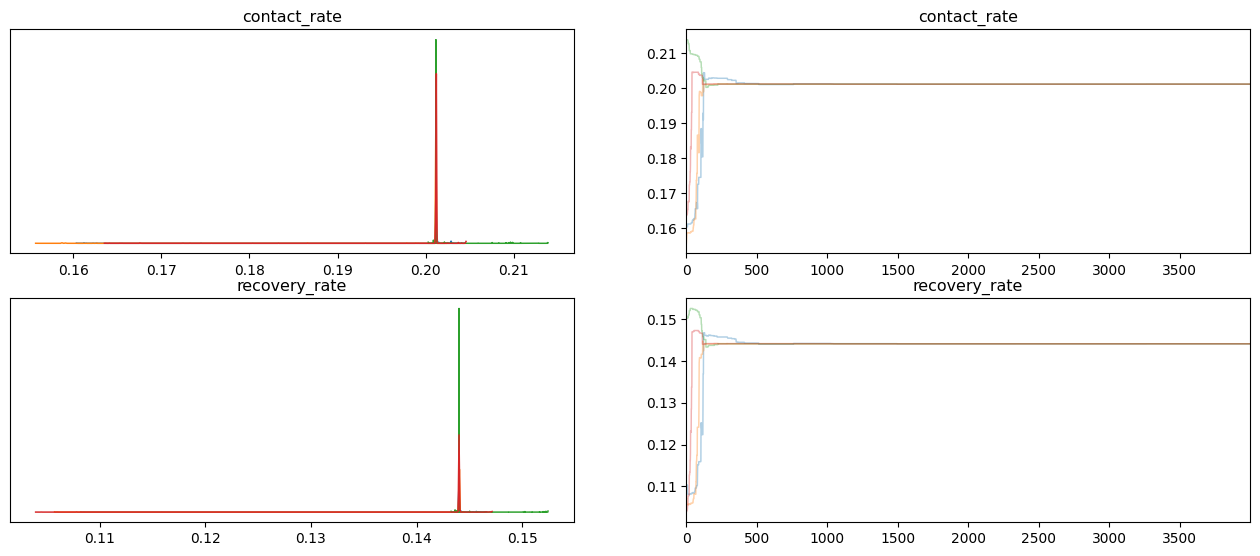

Sampler =  DEMetropolisZ


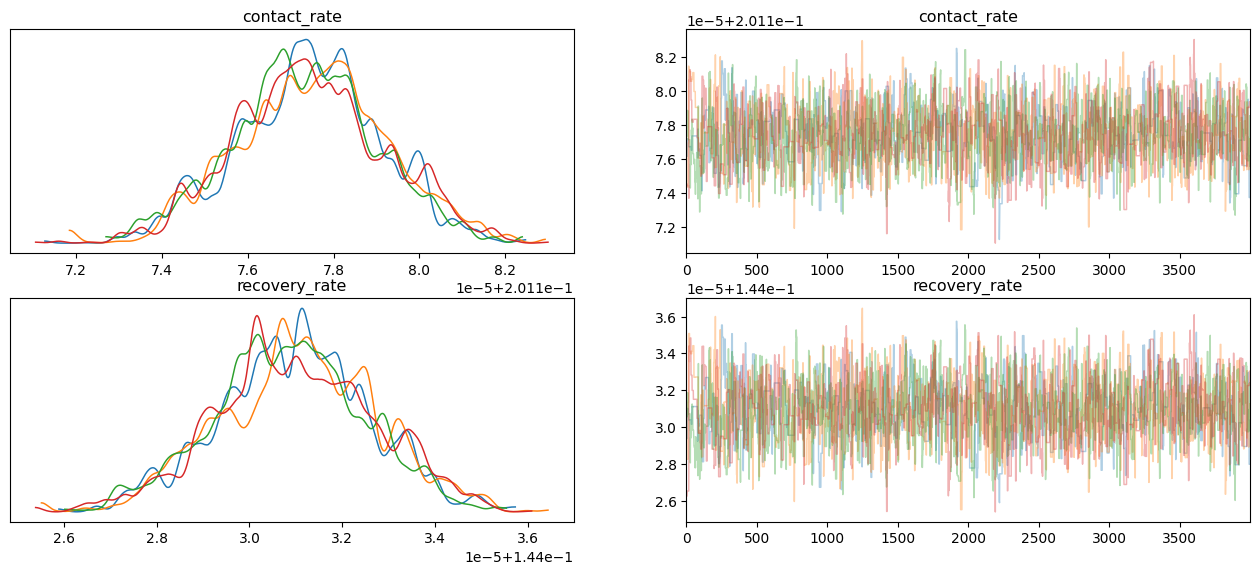

Sampler =  DEMetropolis


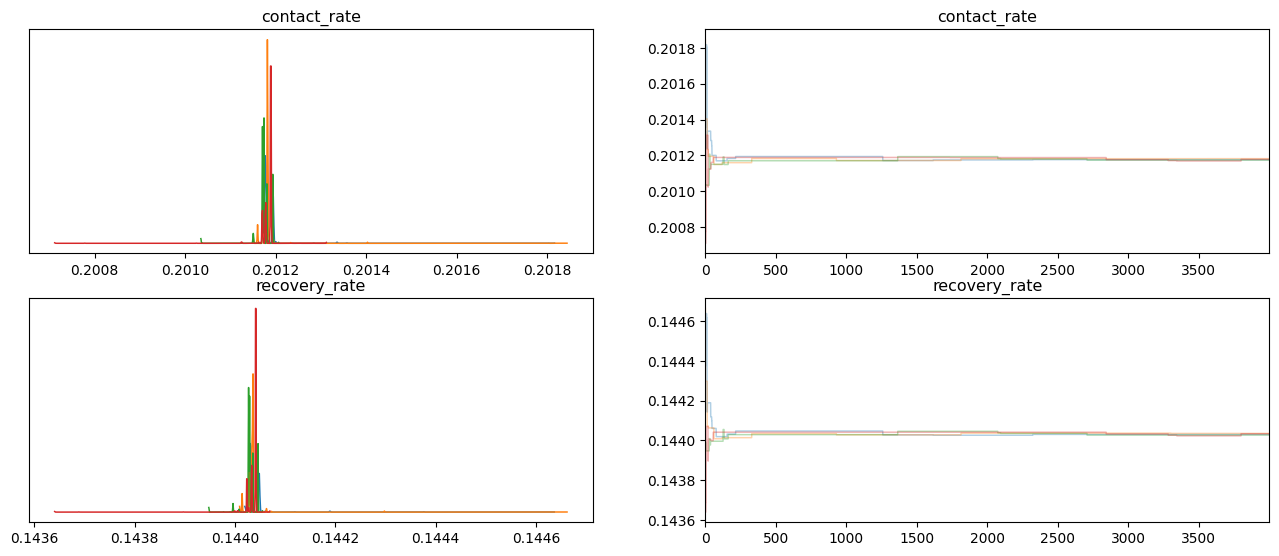

Sampler =  DEMetropolis


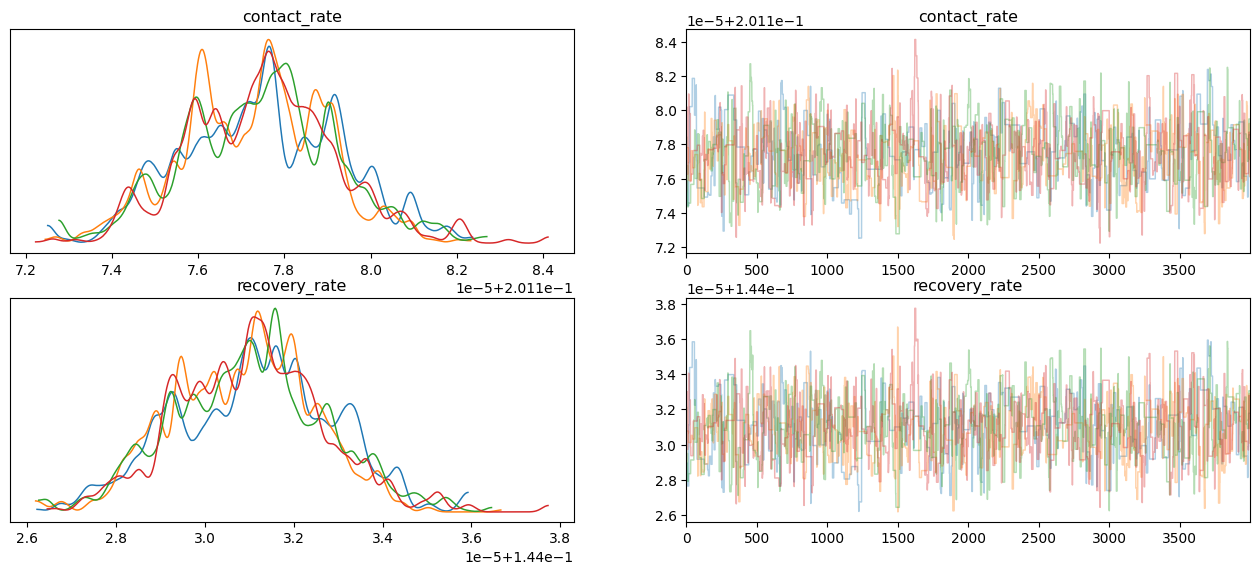

Sampler =  metropolis


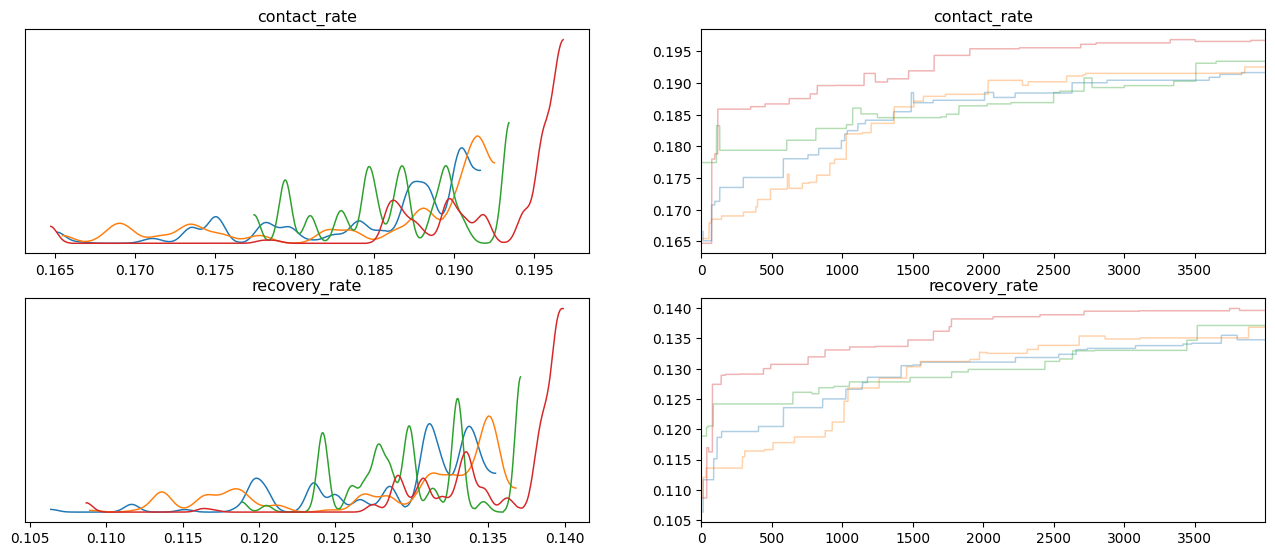

Sampler =  metropolis


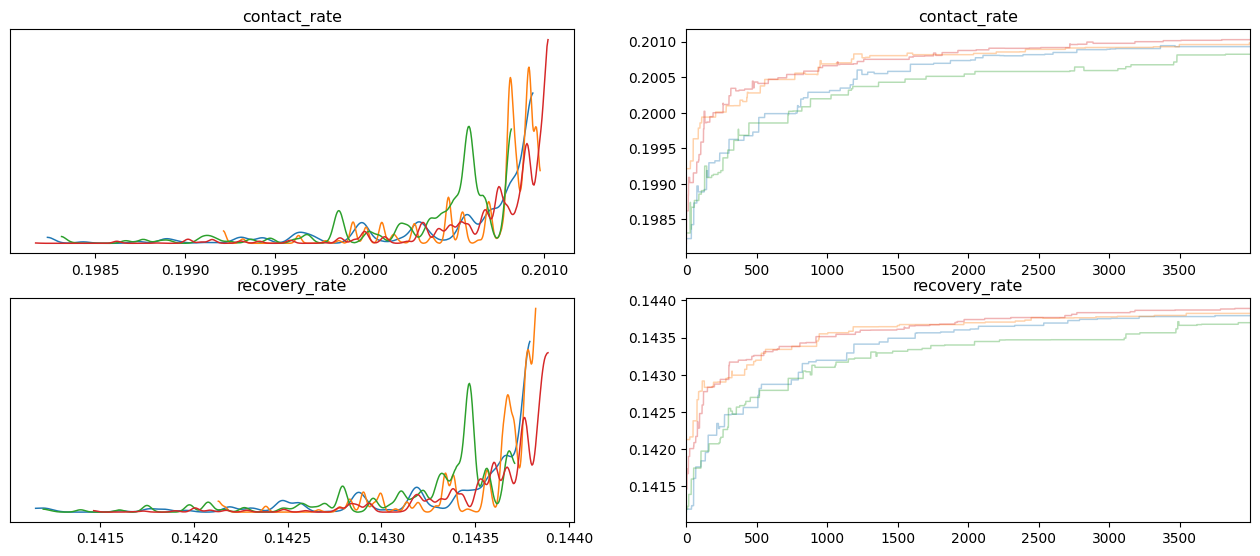

Sampler =  metropolis


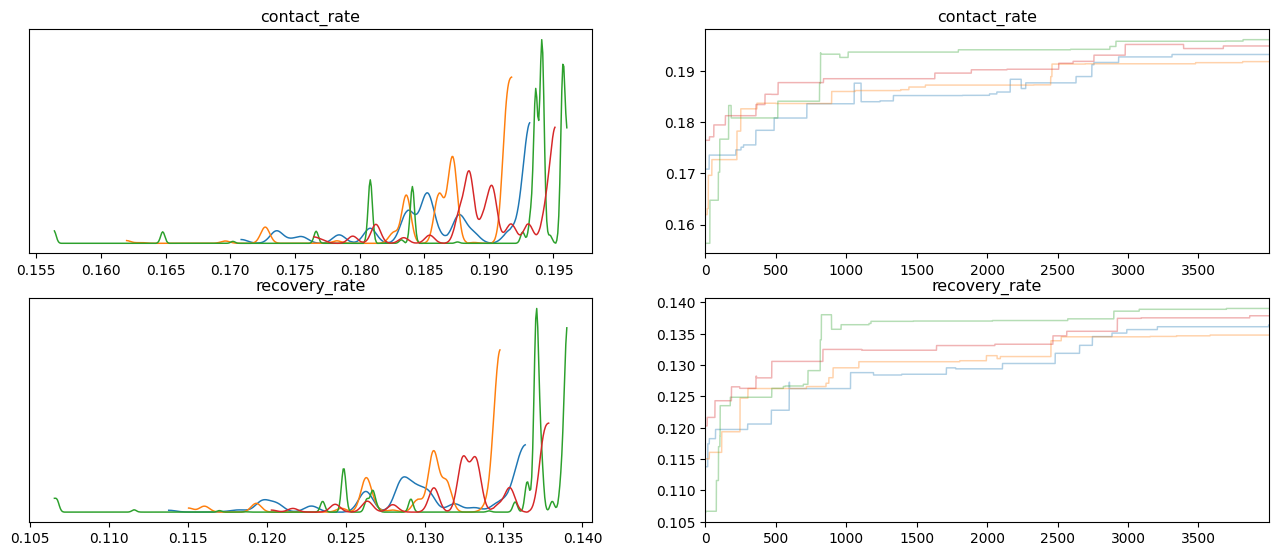

Sampler =  metropolis


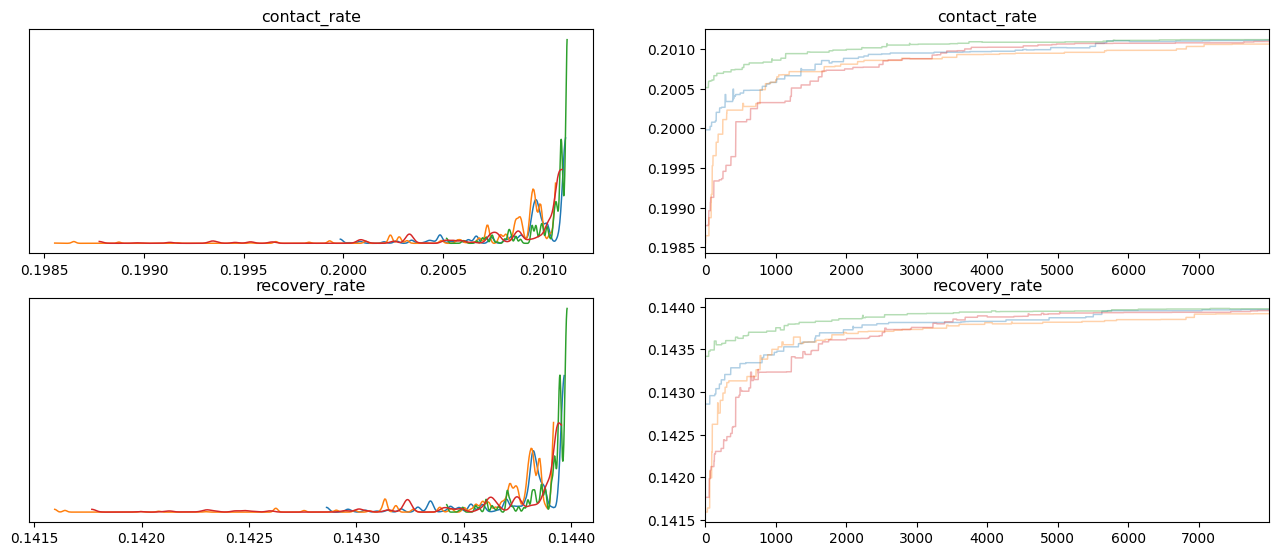

In [35]:
import arviz as az
for idata, sampler in zip(results_df.Trace, results_df.Sampler):
    subset = idata.sel(draw=slice(0, None), groups="posterior")
    print("Sampler = ",sampler)
    az.plot_trace(subset, figsize=(16,3.2*len(subset.posterior)),compact=False)#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);
    plt.show()



In [ ]:
az.ess?

In [19]:
from estival.sampling.tools import likelihood_extras_for_idata
from estival.sampling import tools as esamptools

## Computing the likelihood function for each sampler

In [36]:
map_res = []
map_params = []
for idata, sampler in zip(results_df.Trace, results_df.Sampler):
    if (sampler == "metropolis"):
        # print(sampler)
       likelihood_df = esamptools.likelihood_extras_for_samples(idata.posterior, bcm)

    else :
        likelihood_df = likelihood_extras_for_idata(idata, bcm)
    ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)
    map_parameter = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()
    map_params.append(map_parameter)
    map_res.append(bcm.run(map_parameter))
        



In [37]:
map_params


[{'contact_rate': 0.20117897253376302, 'recovery_rate': 0.14403277390078822},
 {'contact_rate': 0.20117735319224728, 'recovery_rate': 0.1440309028211838},
 {'contact_rate': 0.20117661516081664, 'recovery_rate': 0.14403024881357204},
 {'contact_rate': 0.20117739921851568, 'recovery_rate': 0.14403095275751002},
 {'contact_rate': 0.19674552881230012, 'recovery_rate': 0.13960515035832316},
 {'contact_rate': 0.20102599321854964, 'recovery_rate': 0.14389115856496998},
 {'contact_rate': 0.19607305421675902, 'recovery_rate': 0.13904434564755813},
 {'contact_rate': 0.20112106093272675, 'recovery_rate': 0.14397715891354132}]

In [38]:
# model_1.run(map_params)

pd.DataFrame(
    {
        "DEMetropolisZ": map_res[0].derived_outputs["active_cases"],
        "DEMetropolis": map_res[1].derived_outputs["active_cases"],
        "Metropolis": map_res[2].derived_outputs["active_cases"],
        "Metropolis, 8000 draws": map_res[3].derived_outputs["active_cases"],


        "observed": targets_data,
    }
).plot(kind="scatter", labels=output_labels)


## Uncertainty sampling

## Analysing the posterior likelihood landscape analysis using ELA

In [15]:
# !pip install pflacco
from pflacco.classical_ela_features import *
from pflacco.local_optima_network_features import compute_local_optima_network, calculate_lon_features
#__To___create_a_initial____sample
from pflacco.sampling import create_initial_sample